In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Saved result to output.jpg


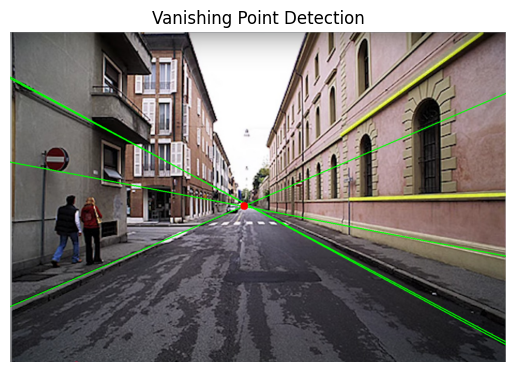

In [42]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# Threshold by which lines will be rejected wrt the horizontal
REJECT_DEGREE_TH = 4.0

def ReadImage(InputImagePath):
    Images = []                     
    ImageNames = []                 
    
    # If path is a file
    if os.path.isfile(InputImagePath):						    
        InputImage = cv2.imread(InputImagePath)                 
        if InputImage is None:
            print("Image not read. Provide a correct path")
            exit()
        
        Images.append(InputImage)                               
        ImageNames.append(os.path.basename(InputImagePath))     

    # If it is neither file nor folder (Invalid Path)
    else:
        print("\nEnter valid Image Path.\n")
        exit()

    return Images, ImageNames

def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1, x2, y2]] = Line

        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2

        theta = math.degrees(math.atan(m))

        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            FinalLines.append([x1, y1, x2, y2, m, c, l])
    
    if len(FinalLines) > 30:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:30]
    
    return FinalLines

def GetLines(Image):
    GrayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
    EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)

    Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)

    if Lines is None:
        print("Not enough lines found in the image.")
        exit(0)
    
    FilteredLines = FilterLines(Lines)

    return FilteredLines

def GetVanishingPoint(Lines):
    VanishingPoint = None
    MinError = 1e12

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)
                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

# Main
if __name__ == "__main__":
    image_path = "/kaggle/input/street/street.jpg"  # Change this to your image path (or full path if needed)

    Images, ImageNames = ReadImage(image_path)
    
    for i in range(len(Images)):
        Image = Images[i]

        Lines = GetLines(Image)

        VanishingPoint = GetVanishingPoint(Lines)

        if VanishingPoint is None:
            print("Vanishing Point not found.")
            continue

        height, width = Image.shape[:2]
        
        for Line in Lines:
            m, c = Line[4], Line[5]
        
            # Extend the line from left to right of the image
            x_start = 0
            y_start = int(m * x_start + c)
            
            x_end = width
            y_end = int(m * x_end + c)
        
            # Only draw if within reasonable vertical limits
            if 0 <= y_start <= height or 0 <= y_end <= height:
                cv2.line(Image, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)



        cv2.circle(Image, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)

        # Save output
        output_path = "output.jpg"
        cv2.imwrite(output_path, Image)
        print(f"Saved result to {output_path}")

        # Show output
        plt.imshow(cv2.cvtColor(Image, cv2.COLOR_BGR2RGB))
        plt.title("Vanishing Point Detection")
        plt.axis("off")
        plt.show()


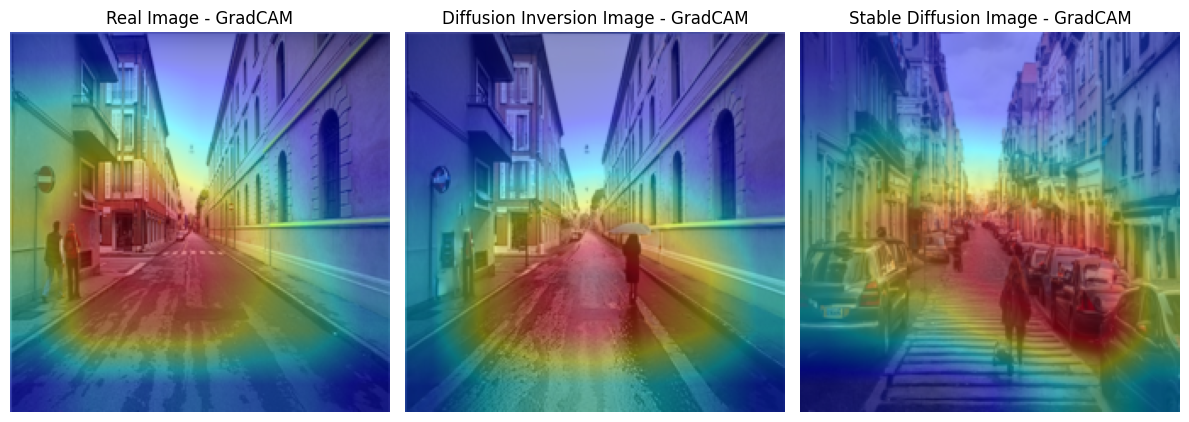

In [57]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms

# --- GradCAM class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, image_tensor, class_idx=None):
        self.model.eval()
        output = self.model(image_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=image_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# --- Heatmap Overlay ---
def apply_heatmap(image_tensor, cam):
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.4 * heatmap / 255.0 + 0.6 * image_np)
    return np.clip(overlay, 0, 1)

# --- Preprocessing ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# --- Load images ---
fake_inv_img_path = '/kaggle/input/inversion/inversion_1.jpg'
fake_sd_img_path = '/kaggle/input/firsttt/first_1.jpg'
real_img_path = '/kaggle/input/street/street.jpg'

real_img = Image.open(real_img_path).convert('RGB')
fake_inv_img = Image.open(fake_inv_img_path).convert('RGB')
fake_sd_img = Image.open(fake_sd_img_path).convert('RGB')

real_tensor = transform(real_img).unsqueeze(0)
fake_inv_tensor = transform(fake_inv_img).unsqueeze(0)
fake_sd_tensor = transform(fake_sd_img).unsqueeze(0)

# --- Load model ---
model = models.resnet18(pretrained=True)
target_layer = model.layer4[1].conv2  # Last conv layer
grad_cam = GradCAM(model, target_layer)

# --- Generate CAMs ---
real_cam = grad_cam.generate(real_tensor)
fake_inv_cam = grad_cam.generate(fake_inv_tensor)
fake_sd_cam = grad_cam.generate(fake_sd_tensor)

# --- Apply heatmaps ---
real_overlay = apply_heatmap(real_tensor, real_cam)
fake_inv_overlay = apply_heatmap(fake_inv_tensor, fake_inv_cam)
fake_sd_overlay = apply_heatmap(fake_sd_tensor, fake_sd_cam)

# --- Side-by-side display ---
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(real_overlay)
axs[0].set_title("Real Image - GradCAM")
axs[0].axis('off')
axs[1].imshow(fake_inv_overlay)
axs[1].set_title("Diffusion Inversion Image - GradCAM")
axs[1].axis('off')
axs[2].imshow(fake_sd_overlay)
axs[2].set_title("Stable Diffusion Image - GradCAM")
axs[2].axis('off')
plt.tight_layout()
save_path="../working/Gradcam_heatmaps.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

Saved result to output.jpg


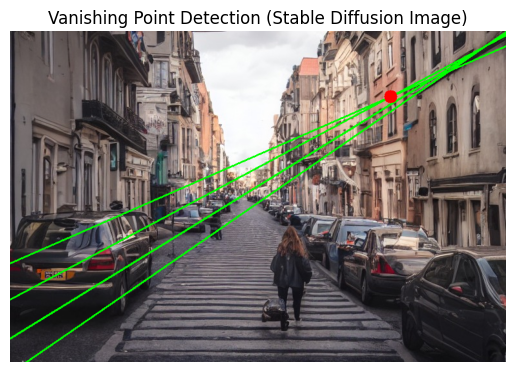

In [56]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# Threshold by which lines will be rejected wrt the horizontal
REJECT_DEGREE_TH = 4.0

def ReadImage(InputImagePath):
    Images = []                     
    ImageNames = []                 
    
    # If path is a file
    if os.path.isfile(InputImagePath):						    
        InputImage = cv2.imread(InputImagePath)                 
        if InputImage is None:
            print("Image not read. Provide a correct path")
            exit()
        
        Images.append(InputImage)                               
        ImageNames.append(os.path.basename(InputImagePath))     

    # If it is neither file nor folder (Invalid Path)
    else:
        print("\nEnter valid Image Path.\n")
        exit()

    return Images, ImageNames

def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1, x2, y2]] = Line

        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2

        theta = math.degrees(math.atan(m))

        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            FinalLines.append([x1, y1, x2, y2, m, c, l])
    
    if len(FinalLines) > 30:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:30]
    
    return FinalLines

def GetLines(Image):
    GrayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
    EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)

    Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)

    if Lines is None:
        print("Not enough lines found in the image.")
        exit(0)
    
    FilteredLines = FilterLines(Lines)

    return FilteredLines

def GetVanishingPoint(Lines):
    VanishingPoint = None
    MinError = 1e12

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)
                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

# Main
if __name__ == "__main__":
    image_path = "/kaggle/input/firsttt/first_1.jpg"  # Change this to your image path (or full path if needed)

    Images, ImageNames = ReadImage(image_path)
    
    for i in range(len(Images)):
        Image = Images[i]

        Lines = GetLines(Image)

        VanishingPoint = GetVanishingPoint(Lines)

        if VanishingPoint is None:
            print("Vanishing Point not found.")
            continue

        height, width = Image.shape[:2]
        
        for Line in Lines:
            m, c = Line[4], Line[5]
        
            # Extend the line from left to right of the image
            x_start = 0
            y_start = int(m * x_start + c)
            
            x_end = width
            y_end = int(m * x_end + c)
        
            # Only draw if within reasonable vertical limits
            if 0 <= y_start <= height or 0 <= y_end <= height:
                cv2.line(Image, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)



        cv2.circle(Image, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)

        # Save output
        output_path = "output.jpg"
        cv2.imwrite(output_path, Image)
        print(f"Saved result to {output_path}")

        # Show output
        plt.imshow(cv2.cvtColor(Image, cv2.COLOR_BGR2RGB))
        plt.title("Vanishing Point Detection (Stable Diffusion Image)")
        plt.axis("off")
        plt.show()

Inversion

Saved result to output.jpg


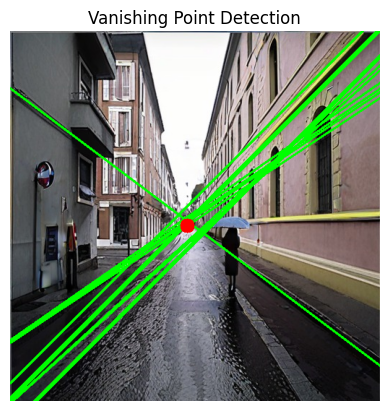

In [43]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# Threshold by which lines will be rejected wrt the horizontal
REJECT_DEGREE_TH = 4.0

def ReadImage(InputImagePath):
    Images = []                     
    ImageNames = []                 
    
    # If path is a file
    if os.path.isfile(InputImagePath):						    
        InputImage = cv2.imread(InputImagePath)                 
        if InputImage is None:
            print("Image not read. Provide a correct path")
            exit()
        
        Images.append(InputImage)                               
        ImageNames.append(os.path.basename(InputImagePath))     

    # If it is neither file nor folder (Invalid Path)
    else:
        print("\nEnter valid Image Path.\n")
        exit()

    return Images, ImageNames

def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1, x2, y2]] = Line

        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2

        theta = math.degrees(math.atan(m))

        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            FinalLines.append([x1, y1, x2, y2, m, c, l])
    
    if len(FinalLines) > 30:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:30]
    
    return FinalLines

def GetLines(Image):
    GrayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
    EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)

    Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)

    if Lines is None:
        print("Not enough lines found in the image.")
        exit(0)
    
    FilteredLines = FilterLines(Lines)

    return FilteredLines

def GetVanishingPoint(Lines):
    VanishingPoint = None
    MinError = 1e12

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)
                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

# Main
if __name__ == "__main__":
    image_path = "/kaggle/input/inversion/inversion_1.jpg"  # Change this to your image path (or full path if needed)

    Images, ImageNames = ReadImage(image_path)
    
    for i in range(len(Images)):
        Image = Images[i]

        Lines = GetLines(Image)

        VanishingPoint = GetVanishingPoint(Lines)

        if VanishingPoint is None:
            print("Vanishing Point not found.")
            continue

        height, width = Image.shape[:2]
        
        for Line in Lines:
            m, c = Line[4], Line[5]
        
            # Extend the line from left to right of the image
            x_start = 0
            y_start = int(m * x_start + c)
            
            x_end = width
            y_end = int(m * x_end + c)
        
            # Only draw if within reasonable vertical limits
            if 0 <= y_start <= height or 0 <= y_end <= height:
                cv2.line(Image, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)



        cv2.circle(Image, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)

        # Save output
        output_path = "output.jpg"
        cv2.imwrite(output_path, Image)
        print(f"Saved result to {output_path}")

        # Show output
        plt.imshow(cv2.cvtColor(Image, cv2.COLOR_BGR2RGB))
        plt.title("Vanishing Point Detection")
        plt.axis("off")
        plt.show()
